In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind # library to perform hypothesis testing

### Import data

In [13]:
data = pd.read_csv('../02_data/02_treated_data/preprocessed_data.csv', index_col=0)

# Exploratory Data Analysis

In [14]:
# Check the size of the dataset (nº of columns and rows)
print(f'Number of rows and columns is {data.shape}')

Number of rows and columns is (1000, 22)


In [15]:
# See the names of the columns and check the type of each one
data.dtypes

Status of existing checking account                         object
Duration in months                                           int64
Credit history                                              object
Purpose                                                     object
Credit amount                                                int64
Savings account/bonds                                       object
Present employment since                                    object
Installment rate in percentage of disposable income          int64
Personal status and sex                                     object
Other debtors / guarantors                                  object
Present residence since                                      int64
Property                                                    object
Age in years                                                 int64
Other installment plans                                     object
Housing                                                     ob

In [16]:
# Check the number of observations with each type of credit risk
data['Credit risk'].value_counts()

Credit risk
0    700
1    300
Name: count, dtype: int64

## 2.1 Visualize the relationship between credit risk and the numerical features

First, I will plot violin plots of each of the 8 numerical features by type of credit risk. This will give us a sense of the distribution of each feature by credit risk type.

In [17]:
num_cols = data.select_dtypes(include='number').columns

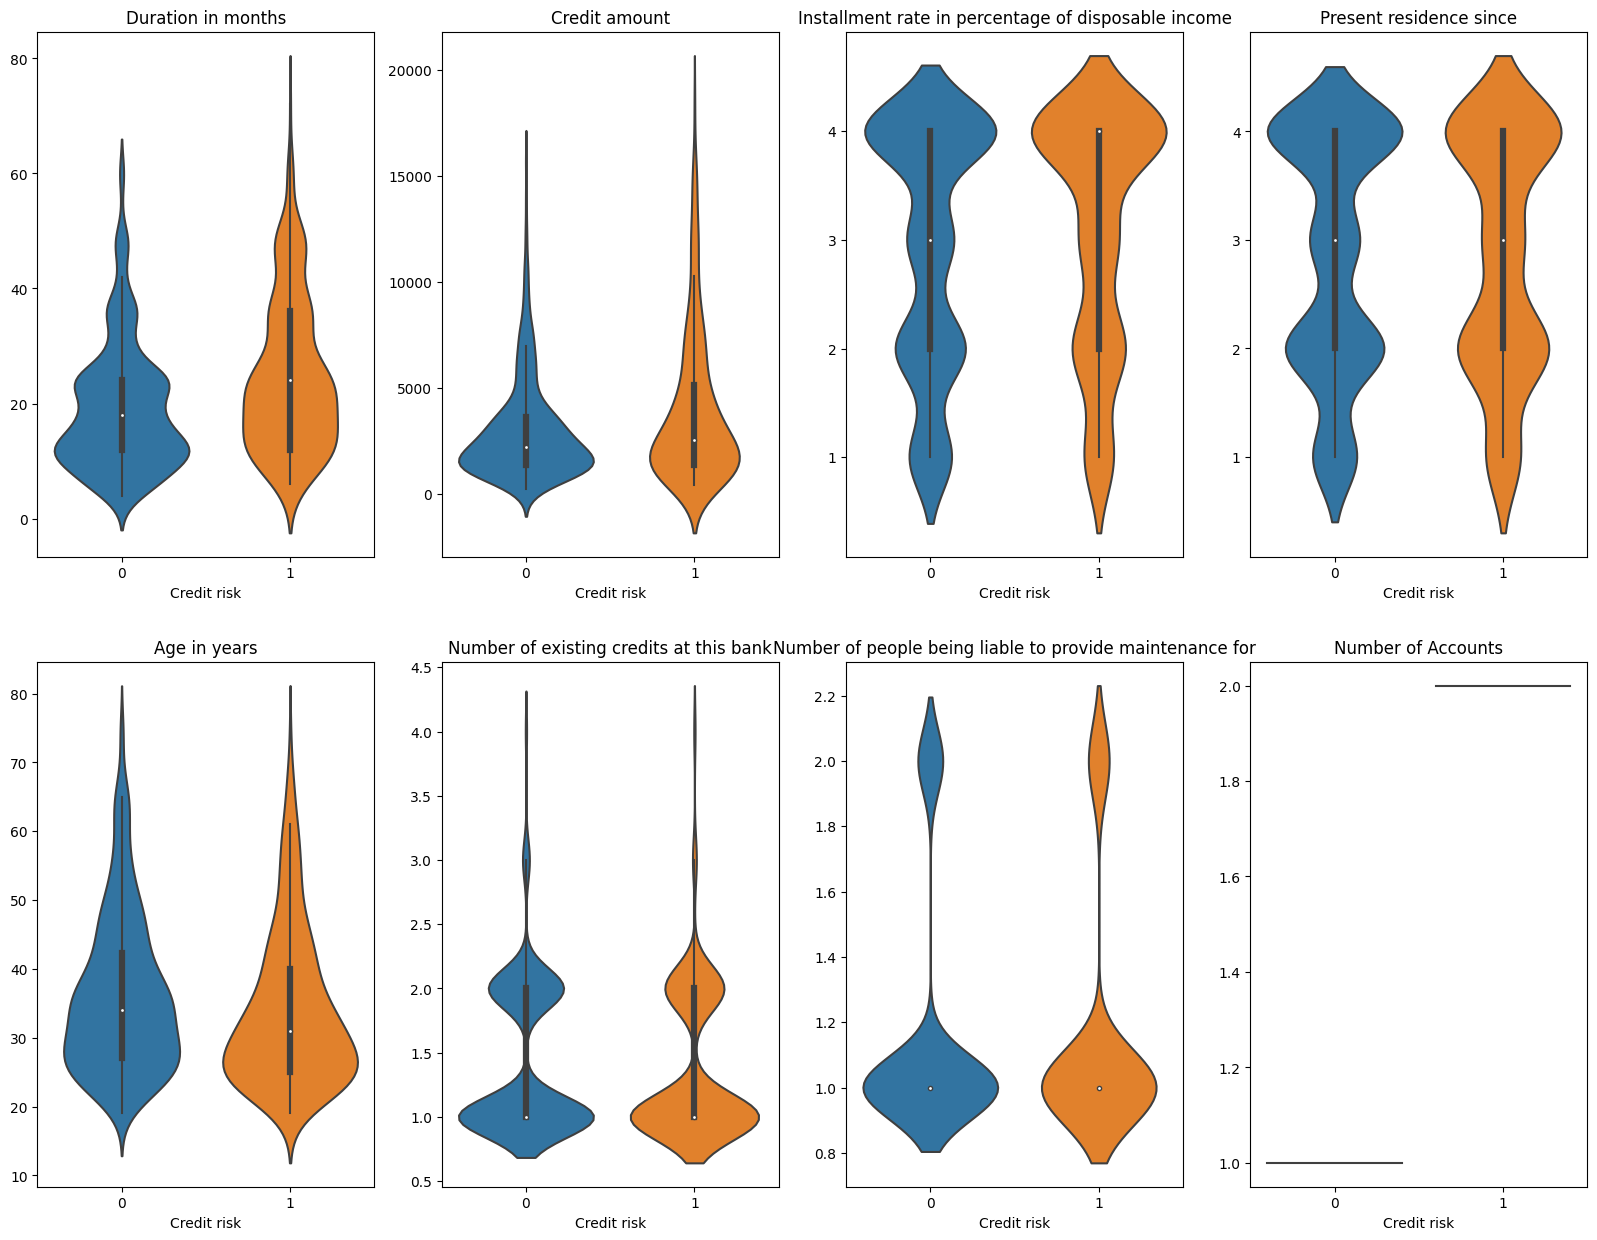

In [18]:
# Get an initial feeling of the data using violin plots
fig, axes = plt.subplots(2, 4, figsize=(20, 15))

for i in range(len(num_cols[num_cols != 'Credit risk'])):

    ax = sns.violinplot(data = data, x = 'Credit risk', y = data[num_cols[num_cols != 'Credit risk'][i]], ax = axes[i // 4, i % 4])
    ax.set_title(num_cols[num_cols != 'Credit risk'][i])
    ax.set_ylabel('')   

In [19]:
print(data.groupby('Credit risk')[['Age in years', 'Duration in months', 'Credit amount']].mean())

             Age in years  Duration in months  Credit amount
Credit risk                                                 
0               36.224286           19.207143    2985.457143
1               33.963333           24.860000    3938.126667


#### Insights:
- We see that there are two values for the number of accounts (1 and 2), and that all applicants with good loans have 1 account, while all applicants with bad loans have 2 accounts. I don't know if this is a coincidence or if there is a reason for this, but I find puzzling to find that. First of all, I am not sure what the number of accounts actually means, and why it is only 1 or 2. From my experience, a person can only have a single account at a financial institution (considering it is a personal account and she is the only owner of it). But even if it was possible to have more than one, why there is no one with 3 or more accounts? But most important, why all applicants with bad loans would have 2 accounts, while applicants with good loans have just 1? If this is indeed correct, then we could use only this feature to perfectly classify the credit risk of loans. I have a felling however that there might be something going on here and that I should not use this variable in the classification. Maybe the loan is classified as bad and then the applicant make another account? In this scenario, the "Number of Accounts" is defined after the loan is classified as bad, so I defitinely should not use it in the prediction.

- Compared to good loans, bad loans have slighly higher durations (good: 19.2 vs bad: 24.9) and higher amounts (good: 2985 vs bad: 3938), and the median of installment rates in percentage of disposable income is higher (good: 3% vs bad: 4%). Holders of bad loans are also slightly younger than holders of good loans on average (good: 36 vs bad: 34)

- We do not see much difference in the features of number of existing credits at this bank, number of dependents, present residence since.

### 2.1.1 Visualize the relationship between Credit risk and the numerical features with discrete values

I will take now the numerical features with discrete values to look at them in more detail.

On the left column of the plot below, we see the number of occurences for each value of the feature by credit risk type. On the right column, we see the percentage of occurences for each value of the feature within each credit risk type.

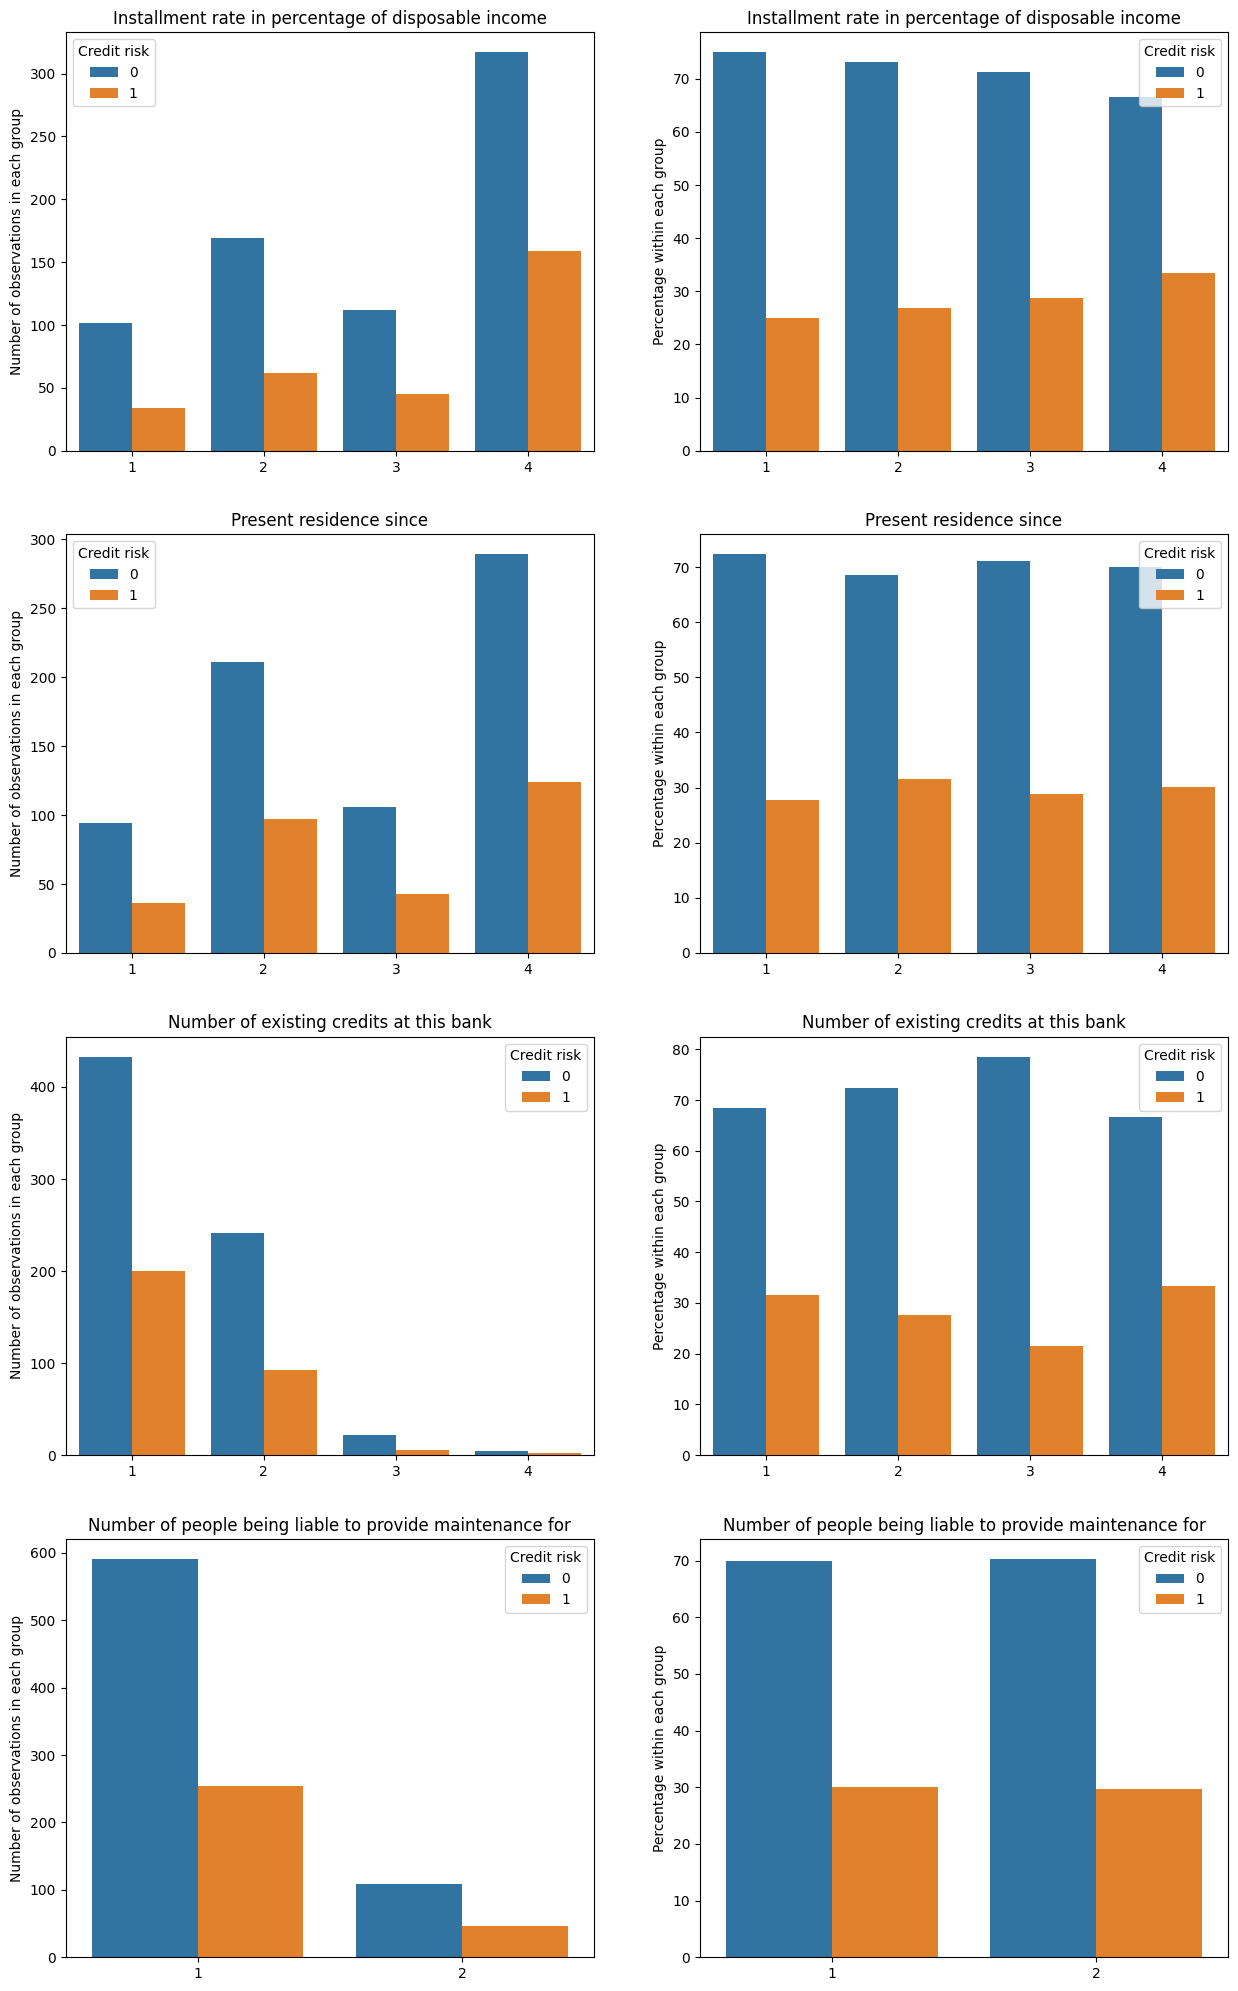

In [20]:
# Select the numerical features with discrete values
discrete_cols = list(['Installment rate in percentage of disposable income', 'Present residence since',
'Number of existing credits at this bank', 'Number of people being liable to provide maintenance for'])

# make the plots
fig, axes = plt.subplots(len(discrete_cols), 2, figsize=(15, 25))

for i in range(len(discrete_cols)):
    
    # Display the number of observations with each type of credit risk within each group
    ax = sns.countplot(x=discrete_cols[i], ax=axes[i, 0], hue='Credit risk', data=data)
    ax.set_title(discrete_cols[i])
    ax.set_ylabel('Number of observations in each group')
    ax.set_xlabel('')

    # Display the percentage of observations with each type of credit risk within each group
    group_percentages = data.groupby([discrete_cols[i], 'Credit risk']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum())
    ax = sns.barplot(x=group_percentages.index.get_level_values(0), y=group_percentages.values, ax=axes[i, 1], hue=group_percentages.index.get_level_values(2))
    ax.set_title(discrete_cols[i])
    ax.set_ylabel('Percentage within each group')
    ax.set_xlabel('')

#### Insights:

- Most loans have an installment rate of 4%. But as this percentage increases from 1% to 4%, the percentage of bad loans among all loans for each installment rate increase as well, which again shows the positive relationship between this feature and the target variable

- We see that the great majority of applicants has a single credit at the bank, which is valid for both types of loans, with few people having 3 or 4 credits.

- Overall, we do not see much difference in the distribution of the features by credit risk type, with the noted exception of the installment rate.

### 2.1.2 Visualize the relationship between credit risk and the numerical features with continuous values

In this subsection, I will plot the empirical cdf of the numerical features by credit risk type, so we can see how the distribution of each feature varies by credit risk type.

Also, I will check if the means of these columns are different for each credit risk type using a hypothesis test for difference in means.

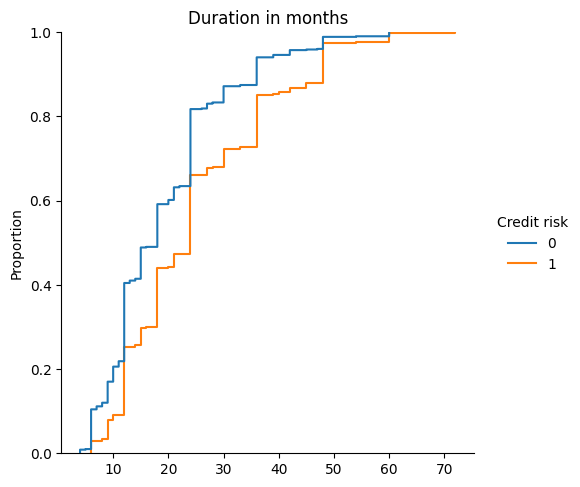

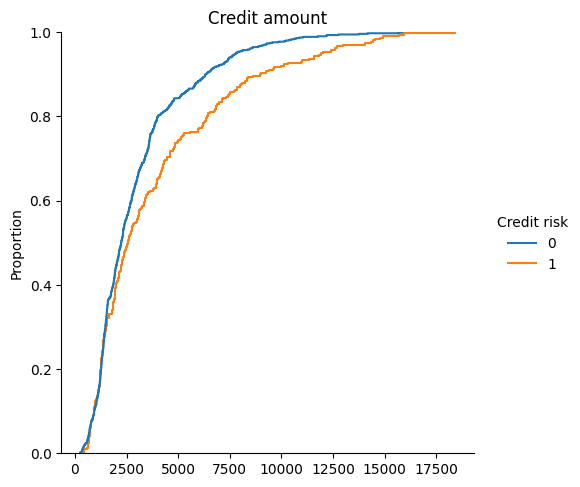

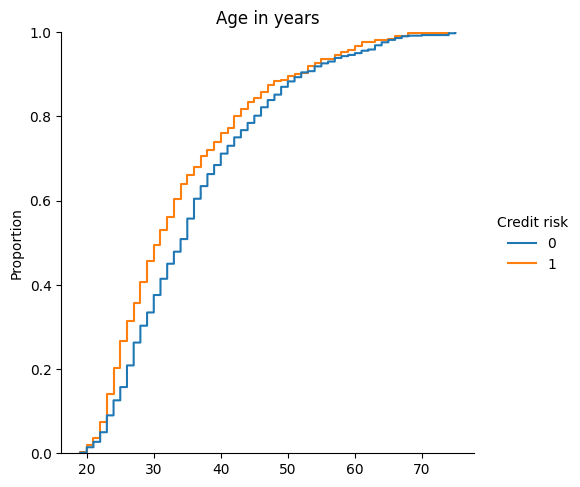

In [21]:
# Select the numerical features with continuous values
continuous_cols = ['Duration in months', 'Credit amount', 'Age in years']

# Plot the graphs
for i in range(len(continuous_cols)):

    # Display the distribution of the values of the continuous columns within each group
    sns.displot(data, x=continuous_cols[i], hue='Credit risk', kind = 'ecdf')
    plt.title(continuous_cols[i])
    plt.xlabel('')

In [22]:
# Do a hypothesis test to check if the means of the continuous columns are different for each type of credit risk
for i in range(len(continuous_cols)):
    print(f'Feature: {continuous_cols[i]}')
    print(f'Mean for each type of credit risk is:')
    print(data.groupby('Credit risk')[continuous_cols[i]].mean())
    print(f'P-value for a difference in means:')
    print(ttest_ind(data[data['Credit risk'] == 0][continuous_cols[i]], data[data['Credit risk'] == 1][continuous_cols[i]]).pvalue)
    print('\n')

Feature: Duration in months
Mean for each type of credit risk is:
Credit risk
0    19.207143
1    24.860000
Name: Duration in months, dtype: float64
P-value for a difference in means:
6.4880498771843485e-12


Feature: Credit amount
Mean for each type of credit risk is:
Credit risk
0    2985.457143
1    3938.126667
Name: Credit amount, dtype: float64
P-value for a difference in means:
8.797572373528894e-07


Feature: Age in years
Mean for each type of credit risk is:
Credit risk
0    36.224286
1    33.963333
Name: Age in years, dtype: float64
P-value for a difference in means:
0.003925339398276282




#### Insights

- We confirm here the insights we drew on the first graph: bad loans have higher duration, higher amount and are requested by younger applicants.

- The cdf of the duration feature for bad loans is completely shifted to the right compared to the cdf of the duration feature for good loans. For the credit amount, we see that both cdfs are the same untill +- 2000, and then the cdf for bad loans is shifted to the right. For the age feature, we see that the cdf for bad loans is also completely shifted to the left compared to the cdf for good loans. 

- The mean values by credit risk for each of these features are indeed different, as we can see from the p-values displayed above.

## 2.2 Visualize the relationship between Credit risk and the categorical features

Now we will look at the categorical features. I will plot the number of occurences for each feature by credit risk type.

In [24]:
cat_cols = data.select_dtypes(include='object').columns

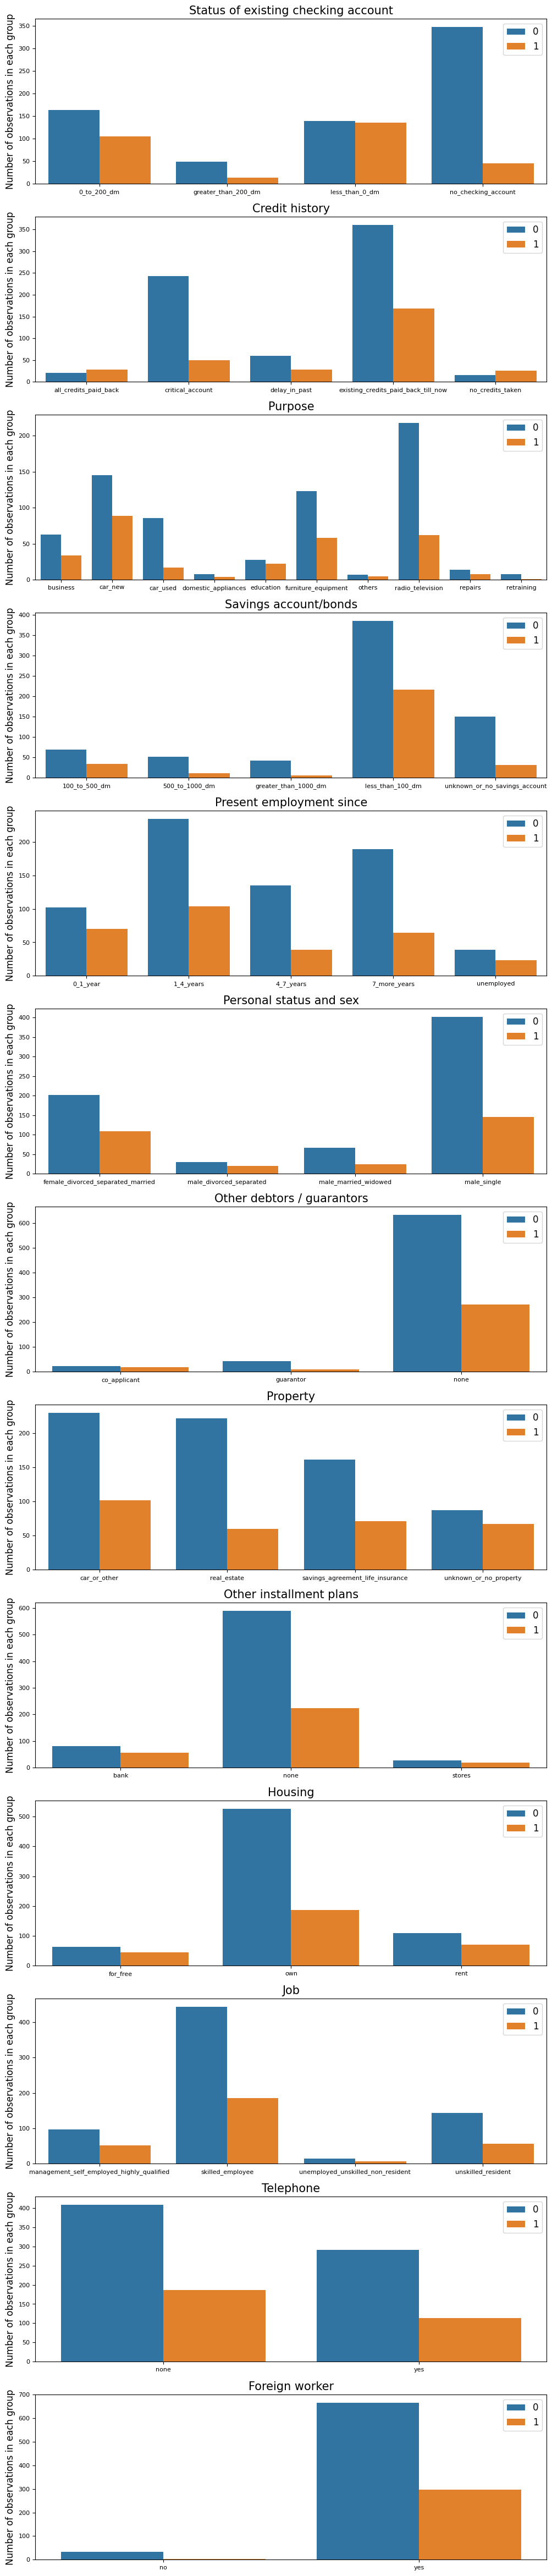

In [25]:
# Plot the graphs
fig, axes = plt.subplots(len(cat_cols), 1, figsize=(12, 60))

for i in range(len(cat_cols)):

    # Display the number of observations with each type of credit risk within each group
    ax = sns.countplot(data = data.sort_values(cat_cols[i]), x = cat_cols[i], hue = 'Credit risk', ax = axes[i])
    ax.set_title(cat_cols[i])
    ax.set_ylabel('Number of observations in each group')
    ax.set_xlabel('')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.yaxis.label.set_size(12)
    ax.title.set_size(15)
    ax.legend(fontsize=12)

#### Insights:

- **Status of existing checking account** & **Savings Account / Bonds** : The more an applicant has on either type of account, the more likely he is to have a good loan. Which makes sense, since people with more money are more likely to pay their loans. Surprisingly though, the great majority of applicants without a checking account or a savings account also have good loans. It might be the case that they do not have an account in this bank, but on another bank, so they actually have the money to pay for their loans.

- **Credit history**: Surprisingly, this variable does not seem to be much correlated with the credit risk of the loan. There is a great number of applicants with a critical account that have a good loan, while the majority of applicants with all credits paid back have bad loans. This raises me a concern as to what is the exact defition of our target variable (is it bad when applicant does not pay a single installment? Or is it bad when the applicant does not pay the full amount of the loan? or something else?)

- **Present employment since**: The longer people have their jobs, the more likely they are to have good loans. This makes sense, since people with longer jobs are more likely to have more money to pay for their loans.

- **Housing**: The proportion of applicants with bad loans is lower among those who own a house relatively to those who rent or live for free. This makes sense, since people who own a house probably have more money to pay for their loans and have more disposable income considering they do not pay rent.

- **Other installment plans**: Among applicants with other installment plans (banks + stores), the proportion of those with bad loans is higher than the proportion of bad loans among applicants with no other installment plan. This suggests that people might fail to pay their loans because they have other loans to pay.

- **Foreign worker**: The majority of applicants are foreign workers, and the proportion of bad loans among them is higher than the proportion of bad loans among non-foreign workers.